In [49]:

from __future__ import annotations
import re
import unicodedata
import numpy as np
import pandas as pd

# =========================================================
# 공통 유틸
# =========================================================

def try_read_csv(path: str) -> pd.DataFrame:
    """인코딩 오류 방지용 CSV 로드 함수"""
    for enc in ["utf-8-sig", "cp949", "euc-kr", "utf-8"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    return pd.read_csv(path, engine="python", encoding_errors="ignore")

def normalize_str(x) -> str | float:
    """문자 표준화(유니코드/공백)"""
    if pd.isna(x):
        return np.nan
    s = unicodedata.normalize("NFKC", str(x))
    s = re.sub(r"\s+", " ", s).strip()
    return s

def parse_yyyymmdd(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip()
    bad = {"nan","NaN","NULL","None","",".", " "}
    s = s.apply(lambda x: np.nan if x in bad else x)
    s = s.str.replace(r"\.", "", regex=True)       # 점 제거
    s = s.str.replace(r"\D", "", regex=True)       # 숫자만
    s = s.str.slice(0, 8)                          # 8자리 제한
    return pd.to_datetime(s, format="%Y%m%d", errors="coerce")

def clean_category(series: pd.Series, default_label="기타") -> pd.Series:
    """카테고리 통일 + 의심값 → '기타'"""
    na_tokens = {"nan","nat","none","null","","-",".","미정","미상","무응답","없음"}
    s = series.map(normalize_str)
    mask_bad = s.str.lower().isin(na_tokens)
    return s.where(~mask_bad, default_label).fillna(default_label).astype("category")


# 1. set1

In [50]:

# =========================================================
# Set1: 점포 메타
# =========================================================
def load_set1(path: str, cutoff="2024-12-31") -> tuple[pd.DataFrame, np.ndarray]:
    df = try_read_csv(path).copy()
    df.columns = [c.strip() for c in df.columns]

    # 원본 컬럼 키 추정(업로드 코드 기준)
    # ENCODED_MCT(가맹점 ID), MCT_BRD_NUM(브랜드코드), HPSN_MCT_ZCD_NM(업종), HPSN_MCT_BZN_CD_NM(상권)
    # ARE_D(개설일), MCT_ME_D(폐업일)
    rename_map = {
        "ENCODED_MCT": "가맹점구분번호",
        "MCT_BRD_NUM": "브랜드구분코드",
        "HPSN_MCT_ZCD_NM": "업종",
        "HPSN_MCT_BZN_CD_NM": "상권",
        "ARE_D": "개설일",
        "MCT_ME_D": "폐업일",
        "MCT_SIGUNGU_NM": "가맹점지역",
        "MCT_NM": "가맹점명",
        "MCT_BSE_AR": "가맹점주소",
    }
    for k, v in rename_map.items():
        if k in df.columns:
            df = df.rename(columns={k: v})

    # 날짜 변환
    if "개설일" in df.columns:
        df["개설일"] = parse_yyyymmdd(df["개설일"])
    if "폐업일" in df.columns:
        df["폐업일"] = parse_yyyymmdd(df["폐업일"])

    # 파생
    df["업종"] = clean_category(df.get("업종", pd.Series(dtype=object)))
    df["상권"] = clean_category(df.get("상권", pd.Series(dtype=object)))
    df["프랜차이즈여부"] = df.get("브랜드구분코드", pd.Series(index=df.index)).notna().astype(int)

        # ----- (중요) 업종 통합 매핑만 적용 -----
    groups = {
        "한식": ["한식", "한정식", "기사식당", "한식뷔페","도시락","구내식당/푸드코트"],
        "카페/커피전문점": ["카페", "커피전문점", "테이크아웃커피", "테마카페","차"],
        "베이커리/디저트": ["베이커리", "아이스크림/빙수", "마카롱", "와플/크로플", "도너츠", "주스","탕후루","떡/한과","유제품"],
        "일식": ["일식", "일식당"],
        "중식": ["중식", "중식당"],
        "식료품/담배": ["식료품","농산물", "청과물","수산물", "건어물","미곡상","담배","인삼제품", "건강식품", "건강원"],
        "식품 제조":["식품 제조","반찬","떡/한과 제조"],
        "주류/유흥": [
            "호프/맥주", "요리주점", "일반 유흥주점", "포장마차", "이자카야",
            "룸살롱/단란주점", "와인바", "와인샵", "민속주점", "주류"
        ],
        "기타세계요리/꼬치구이":["동남아/인도음식","기타세계요리","꼬치구이"],
        "양식":["양식","스테이크"],
        "샌드위치/토스트/햄버거":["샌드위치/토스트","햄버거"]
    }
    reverse_map = {raw: merged for merged, raws in groups.items() for raw in raws}

    # ----- 매핑 소스: '업종'의 '-' 앞 부분만 사용 -----
    if "업종" in df.columns:
        tmp = df["업종"].astype(str).str.split("-", n=1, expand=True)
        base = tmp[0].str.strip()
        df["업종_통합"] = base.map(reverse_map).fillna(base).astype("category")
    else:
        df["업종_통합"] = pd.Series(pd.NA, index=df.index, dtype="category")
    
    #상권정리 생성
    sk = df["상권"].astype(str).str.strip().replace({"nan": np.nan})
    counts = sk.value_counts(dropna=False)
    freq = sk.map(counts).fillna(0)

    df["상권_정리"] = sk.where(freq > 1, other="기타").fillna("기타").astype("category")
    
    # (중요) 폐업 라벨: "폐업일 > 2024-12-31" 만 1
    cutoff_ts = pd.to_datetime(cutoff)
    df["폐업여부"] = (df["폐업일"] > cutoff_ts).astype(int)

    # 생존기간(관측 종료 = 폐업일 또는 cutoff)
    df["end_date"] = df["폐업일"].fillna(cutoff_ts)
    df["tenure_days"] = (df["end_date"] - df["개설일"]).dt.days
    df = df[df["개설일"].notna()].copy()

    closed_codes = df.loc[df["폐업여부"] == 1, "가맹점구분번호"].dropna().unique()
    return df, closed_codes



- 업종 통합 mapping 진행
- 상권에서 가게 1개짜리 상권은 기타로 처리

# 2. set2

In [51]:
# =========================================================
# Set2: 월별 성과/등급 데이터
# =========================================================
_ORDINAL_COLS_RAW = [
    "MCT_OPE_MS_CN","RC_M1_SAA","RC_M1_TO_UE_CT","RC_M1_UE_CUS_CN","RC_M1_AV_NP_AT","APV_CE_RAT"
]
def _extract_level(x):
    if pd.isna(x): return np.nan
    m = re.match(r"\s*([1-6])", str(x))
    return float(m.group(1)) if m else np.nan

def load_set2(path: str) -> pd.DataFrame:
    df = try_read_csv(path).copy()
    df.columns = [c.strip() for c in df.columns]

    # 결측 코드 정리
    for c in ["DLV_SAA_RAT","M12_SME_BZN_ME_MCT_RAT"]:
        if c in df.columns:
            df[c] = df[c].replace(-999999.9, np.nan)

    # 기준년월
    if "TA_YM" in df.columns:
        df["TA_YM"] = pd.to_datetime(df["TA_YM"], format="%Y%m", errors="coerce")

    # 0 → NaN 규칙(요청 로직): 동일업종 매출금액/건수 비율이 동시 0이면 둘 다 NaN
    pair_cols = ("M1_SME_RY_SAA_RAT", "M1_SME_RY_CNT_RAT")
    if all(c in df.columns for c in pair_cols):
        for c in pair_cols:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        mask_both_zero = (df[pair_cols[0]] == 0) & (df[pair_cols[1]] == 0)
        df.loc[mask_both_zero, list(pair_cols)] = np.nan

    # 배달 매출 비율: NaN → 0 (분석 편의 선택)
    if "DLV_SAA_RAT" in df.columns:
        df["DLV_SAA_RAT"] = df["DLV_SAA_RAT"].fillna(0)

    # 0 → NaN: 동일상권 내 매출순위 비율(명시 케이스)
    if "M12_SME_BZN_SAA_PCE_RT" in df.columns:
        df["M12_SME_BZN_SAA_PCE_RT"] = df["M12_SME_BZN_SAA_PCE_RT"].replace(0, np.nan)

    # 순서형 등급 파생 *_ord
    for col in _ORDINAL_COLS_RAW:
        if col in df.columns:
            df[col + "_ord"] = df[col].apply(_extract_level).astype("float")

    # 한글 컬럼 매핑
    rename_map = {
        "ENCODED_MCT": "가맹점구분번호",
        "TA_YM": "기준년월",
        "MCT_OPE_MS_CN": "가맹점_운영개월수_구간",
        "RC_M1_SAA": "매출금액_구간",
        "RC_M1_TO_UE_CT": "매출건수_구간",
        "RC_M1_UE_CUS_CN": "유니크고객수_구간",
        "RC_M1_AV_NP_AT": "객단가_구간",
        "APV_CE_RAT": "취소율_구간",
        "DLV_SAA_RAT": "배달매출금액_비율",
        "M1_SME_RY_SAA_RAT": "동일업종_매출금액_비율",
        "M1_SME_RY_CNT_RAT": "동일업종_매출건수_비율",
        "M12_SME_RY_SAA_PCE_RT": "동일업종_내_매출순위_비율",
        "M12_SME_BZN_SAA_PCE_RT": "동일상권_내_매출순위_비율",
        "M12_SME_RY_ME_MCT_RAT": "동일업종_내_해지_가맹점_비중",
        "M12_SME_BZN_ME_MCT_RAT": "동일상권_내_해지_가맹점_비중",
        # *_ord
        "MCT_OPE_MS_CN_ord": "가맹점_운영개월수_구간_ord",
        "RC_M1_SAA_ord": "매출금액_구간_ord",
        "RC_M1_TO_UE_CT_ord": "매출건수_구간_ord",
        "RC_M1_UE_CUS_CN_ord": "유니크고객수_구간_ord",
        "RC_M1_AV_NP_AT_ord": "객단가_구간_ord",
        "APV_CE_RAT_ord": "취소율_구간_ord",
    }
    df = df.rename(columns=rename_map)

    # 자료형 정리
    if "기준년월" in df.columns:
        df["기준년월"] = pd.to_datetime(df["기준년월"], errors="coerce")
    return df


# 3. set3

In [52]:
# =========================================================
# Set3: 고객구성/유형 비중
# =========================================================
def load_set3(path: str) -> pd.DataFrame:
    df = try_read_csv(path).copy()
    df.columns = [c.strip() for c in df.columns]

    # 기준년월
    if "TA_YM" in df.columns:
        df["TA_YM"] = pd.to_datetime(df["TA_YM"], format="%Y%m", errors="coerce")

    # 한글 매핑
    rename_map = {
        "ENCODED_MCT": "가맹점구분번호",
        "TA_YM": "기준년월",
        "M12_MAL_1020_RAT": "남성_20대이하_고객비중",
        "M12_MAL_30_RAT": "남성_30대_고객비중",
        "M12_MAL_40_RAT": "남성_40대_고객비중",
        "M12_MAL_50_RAT": "남성_50대_고객비중",
        "M12_MAL_60_RAT": "남성_60대이상_고객비중",
        "M12_FME_1020_RAT": "여성_20대이하_고객비중",
        "M12_FME_30_RAT": "여성_30대_고객비중",
        "M12_FME_40_RAT": "여성_40대_고객비중",
        "M12_FME_50_RAT": "여성_50대_고객비중",
        "M12_FME_60_RAT": "여성_60대이상_고객비중",
        "MCT_UE_CLN_REU_RAT": "재방문_고객비중",
        "MCT_UE_CLN_NEW_RAT": "신규_고객비중",
        "RC_M1_SHC_RSD_UE_CLN_RAT": "거주_이용_고객비율",
        "RC_M1_SHC_WP_UE_CLN_RAT": "직장_이용_고객비율",
        "RC_M1_SHC_FLP_UE_CLN_RAT": "유동인구_이용_고객비율",
    }
    for k, v in rename_map.items():
        if k in df.columns:
            df = df.rename(columns={k: v})

    # 특수 결측값
    df = df.replace(-999999.9, np.nan)

    if "기준년월" in df.columns:
        df["기준년월"] = pd.to_datetime(df["기준년월"], errors="coerce")
    return df



# 4. 병합

In [53]:
# =========================================================
# 병합 및 라벨 부착
# =========================================================
def merge_monthly(set2: pd.DataFrame, set3: pd.DataFrame) -> pd.DataFrame:
    """키: (가맹점구분번호, 기준년월) inner join"""
    for c in ["기준년월"]:
        if c in set2: set2[c] = pd.to_datetime(set2[c], errors="coerce")
        if c in set3: set3[c] = pd.to_datetime(set3[c], errors="coerce")
    merged = pd.merge(
        set2, set3,
        on=["가맹점구분번호", "기준년월"],
        how="inner"
    )
    return merged

def attach_closed_label(monthly: pd.DataFrame, closed_codes: np.ndarray) -> pd.DataFrame:
    monthly = monthly.copy()
    monthly["폐업여부"] = monthly["가맹점구분번호"].isin(closed_codes).astype(int)
    return monthly

# =========================================================
# 메인 진입점
# =========================================================
def build_dataset(
    path_set1: str,
    path_set2: str,
    path_set3: str,
    cutoff: str = "2024-12-31"
) -> dict:
    """
    Returns:
      {
        'set1': 점포 메타(폐업여부 포함),
        'set2': 전처리된 set2,
        'set3': 전처리된 set3,
        'merged': 월단위 병합 + 폐업여부 라벨,
        'closed_codes': np.ndarray (폐업 점포 코드)
      }
    """
    set1, closed_codes = load_set1(path_set1, cutoff=cutoff)
    set2 = load_set2(path_set2)
    set3 = load_set3(path_set3)
    merged = merge_monthly(set2, set3)
    merged = attach_closed_label(merged, closed_codes)
    merged = merged.merge(
        set1[
            ["가맹점구분번호", "업종_통합", "상권_정리", "프랜차이즈여부"]
        ],
        on="가맹점구분번호",
        how="left"
    )
    return {
        "set1": set1,
        "set2": set2,
        "set3": set3,
        "merged": merged,
        "closed_codes": closed_codes,
    }

if __name__ == "__main__":
    # 예시 경로 (원하는 경로로 교체)
    PATH1 = r"C:/Users/eunseok/Desktop/빅콘테스트/1456289/big_data_set1_f.csv"
    PATH2 = r"C:/Users/eunseok/Desktop/빅콘테스트/1456289/big_data_set2_f.csv"
    PATH3 = r"C:/Users/eunseok/Desktop/빅콘테스트/1456289/big_data_set3_f.csv"

    data = build_dataset(PATH1, PATH2, PATH3, cutoff="2024-12-31")
    for k, v in data.items():
        if isinstance(v, pd.DataFrame):
            print(f"[{k}] shape={v.shape}")
    print("폐업 가맹점 수:", len(data["closed_codes"]))

[set1] shape=(4185, 15)
[set2] shape=(86590, 21)
[set3] shape=(86590, 17)
[merged] shape=(86590, 40)
폐업 가맹점 수: 97


In [54]:


data = build_dataset(PATH1, PATH2, PATH3, cutoff="2024-12-31")
set1   = data["set1"]        # 점포 메타(폐업여부 포함)
set2   = data["set2"]        # 전처리된 월별 성과/등급
set3   = data["set3"]        # 전처리된 고객구성
merged = data["merged"]      # (가맹점,월) 병합 + 폐업여부 라벨

In [55]:
merged.head()

,가맹점구분번호,기준년월,가맹점_운영개월수_구간,매출금액_구간,매출건수_구간,유니크고객수_구간,객단가_구간,취소율_구간,배달매출금액_비율,동일업종_매출금액_비율,...,여성_60대이상_고객비중,재방문_고객비중,신규_고객비중,거주_이용_고객비율,직장_이용_고객비율,유동인구_이용_고객비율,폐업여부,업종_통합,상권_정리,프랜차이즈여부
0,000F03E44A,2024-04-01,4_50-75%,5_75-90%,5_75-90%,5_75-90%,5_75-90%,1_상위1구간,0.0,2.6,...,6.0273,5.00,45.00,12.5,12.5,75.0,0,중식,뚝섬,0.0
1,000F03E44A,2023-12-01,4_50-75%,6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),NaN,0.0,NaN,...,0.0000,0.00,0.00,NaN,NaN,NaN,0,중식,뚝섬,0.0
2,002816BA73,2024-04-01,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,6_상위6구간(하위1구간),0.0,96.6,...,2.2352,10.66,6.12,23.8,23.8,52.4,0,주류/유흥,마장동,0.0
3,002816BA73,2024-11-01,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,6_상위6구간(하위1구간),0.0,108.0,...,3.3415,10.41,6.30,11.5,11.5,76.9,0,주류/유흥,마장동,0.0
4,002816BA73,2024-06-01,2_10-25%,4_50-75%,4_50-75%,4_50-75%,2_10-25%,1_상위1구간,0.0,74.2,...,2.0480,9.86,4.69,13.0,17.4,69.6,0,주류/유흥,마장동,0.0


In [56]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86590 entries, 0 to 86589
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   가맹점구분번호           86590 non-null  object        
 1   기준년월              86590 non-null  datetime64[ns]
 2   가맹점_운영개월수_구간      86590 non-null  object        
 3   매출금액_구간           86590 non-null  object        
 4   매출건수_구간           86590 non-null  object        
 5   유니크고객수_구간         86590 non-null  object        
 6   객단가_구간            86590 non-null  object        
 7   취소율_구간            79958 non-null  object        
 8   배달매출금액_비율         86590 non-null  float64       
 9   동일업종_매출금액_비율      79879 non-null  float64       
 10  동일업종_매출건수_비율      79879 non-null  float64       
 11  동일업종_내_매출순위_비율    86590 non-null  float64       
 12  동일상권_내_매출순위_비율    65171 non-null  float64       
 13  동일업종_내_해지_가맹점_비중  86590 non-null  float64       
 14  동일상권_내_해지_가맹점_비중  6517

상권_정리
기타        21495
성수        15828
왕십리       11049
뚝섬         9194
한양대        6866
마장동        5696
금남시장       5288
답십리        3598
옥수         2558
신금호        2058
행당         1839
장한평자동차      810
Name: count, dtype: int64


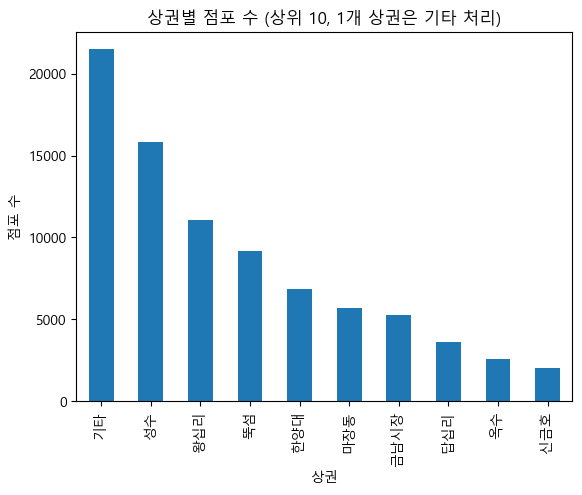

In [57]:
# 상권별 점포 수 계산
counts = merged["상권_정리"].value_counts()


# 처리 후 확인
print(merged["상권_정리"].value_counts().head(20))

# 다시 plot
import matplotlib.pyplot as plt

merged["상권_정리"].value_counts().head(10).plot(kind="bar")
plt.title("상권별 점포 수 (상위 10, 1개 상권은 기타 처리)")
plt.xlabel("상권")
plt.ylabel("점포 수")
plt.show()

# 한글설정(깨짐방지)

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
# ---- 한글 폰트 설정 ----
# (Windows) 보통 'Malgun Gothic'
plt.rc('font', family='Malgun Gothic')  
# (Mac) 보통 'AppleGothic'
# plt.rc('font', family='AppleGothic')
# (Linux, Colab) 나눔글꼴 경로 지정 필요할 수 있음
# plt.rc('font', family='NanumGothic')

plt.rc('axes', unicode_minus=False)  # 마이너스 기호 깨짐 방지

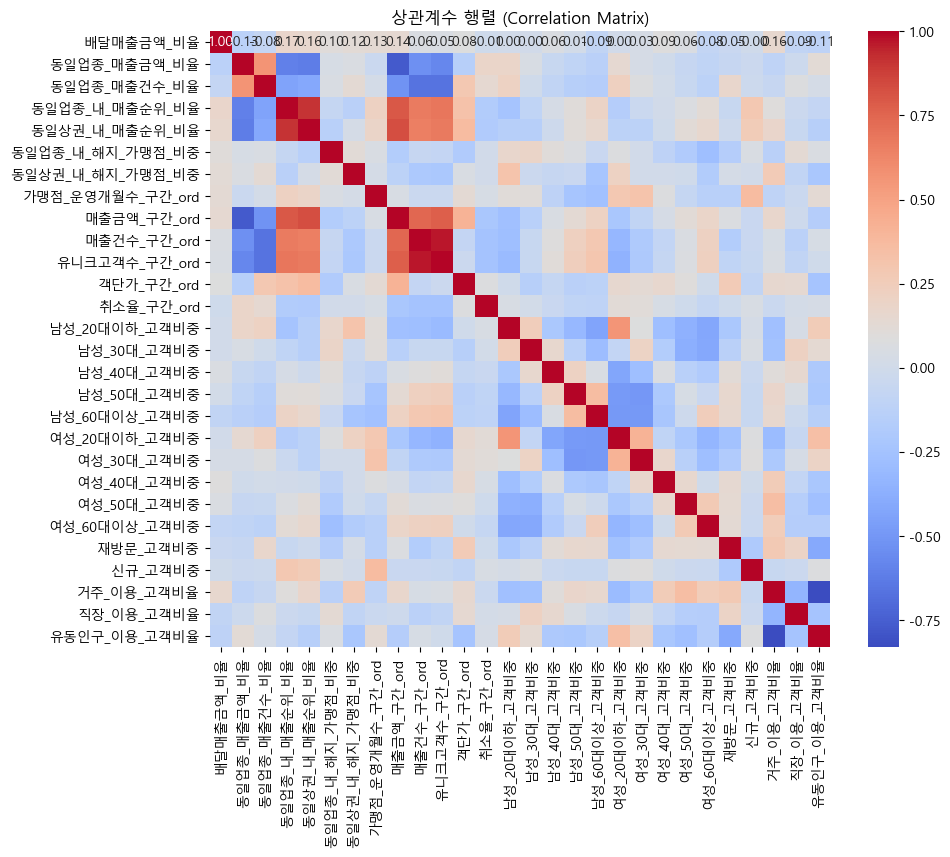

            Variable           VIF
0              const  7.130061e+06
1          배달매출금액_비율  1.183273e+00
2       동일업종_매출금액_비율  2.896815e+00
3       동일업종_매출건수_비율  2.149484e+00
4     동일업종_내_매출순위_비율  7.360101e+00
5     동일상권_내_매출순위_비율  9.447351e+00
6   동일업종_내_해지_가맹점_비중  1.275141e+00
7   동일상권_내_해지_가맹점_비중  1.524281e+00
8   가맹점_운영개월수_구간_ord  1.482595e+00
9        매출금액_구간_ord  7.825911e+00
10       매출건수_구간_ord  1.443669e+01
11     유니크고객수_구간_ord  1.386876e+01
12        객단가_구간_ord  4.379099e+00
13        취소율_구간_ord  1.085545e+00
14     남성_20대이하_고객비중  2.484546e+04
15       남성_30대_고객비중  1.469022e+04
16       남성_40대_고객비중  9.383600e+03
17       남성_50대_고객비중  1.745328e+04
18     남성_60대이상_고객비중  2.255700e+04
19     여성_20대이하_고객비중  3.150570e+04
20       여성_30대_고객비중  1.227624e+04
21       여성_40대_고객비중  5.913978e+03
22       여성_50대_고객비중  7.391977e+03
23     여성_60대이상_고객비중  2.026990e+04
24          재방문_고객비중  1.901238e+00
25           신규_고객비중  1.868324e+00
26        거주_이용_고객비율  2.701937e+05
27        직장_이용_고객비율

In [59]:


plt.rcParams['axes.unicode_minus'] = False  # minus 기호 깨짐 방지


# 분석 대상 열 (수치형 또는 인코딩된 ordinal 변수만 포함)
cols_for_check = [
    "배달매출금액_비율","동일업종_매출금액_비율","동일업종_매출건수_비율","동일업종_내_매출순위_비율",
    "동일상권_내_매출순위_비율","동일업종_내_해지_가맹점_비중","동일상권_내_해지_가맹점_비중",
    "가맹점_운영개월수_구간_ord","매출금액_구간_ord","매출건수_구간_ord","유니크고객수_구간_ord",
    "객단가_구간_ord","취소율_구간_ord",
    "남성_20대이하_고객비중","남성_30대_고객비중","남성_40대_고객비중","남성_50대_고객비중","남성_60대이상_고객비중",
    "여성_20대이하_고객비중","여성_30대_고객비중","여성_40대_고객비중","여성_50대_고객비중","여성_60대이상_고객비중",
    "재방문_고객비중","신규_고객비중","거주_이용_고객비율","직장_이용_고객비율","유동인구_이용_고객비율"
]


# 1. 상관계수 행렬 시각화
corr = merged[cols_for_check].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("상관계수 행렬 (Correlation Matrix)")
plt.show()

# 2. VIF 계산
X = add_constant(merged[cols_for_check].dropna())  # 상수항 추가
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)


# PCA(업종내 매출금액,건수 비율 대상)

▶ 주성분별 설명 분산 비율(%)
PC1    95.655659
PC2     4.344341
dtype: float64

▶ 각 변수의 주성분 로딩(기여도)
                     PC1       PC2
동일업종_내_매출순위_비율  0.707107  0.707107
동일상권_내_매출순위_비율  0.707107 -0.707107


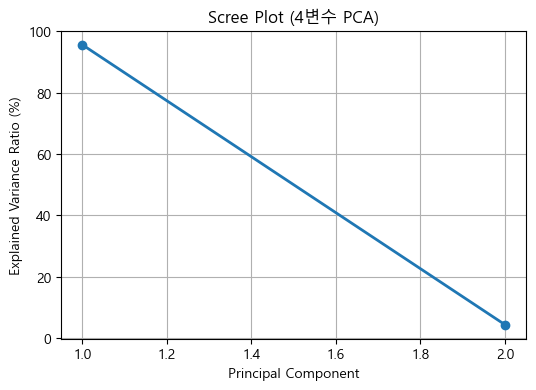

In [60]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ① PCA 대상 변수
cols = [
    "동일업종_내_매출순위_비율",
    "동일상권_내_매출순위_비율"
]

# ② 결측 제거 & 표준화
X = merged[cols].dropna()
X_scaled = StandardScaler().fit_transform(X)

# ③ PCA 수행
pca = PCA()
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

# ④ 결과 요약
explained = pca.explained_variance_ratio_ * 100
loadings = pd.DataFrame(pca.components_.T, index=cols,
                        columns=[f"PC{i+1}" for i in range(len(cols))])

print("▶ 주성분별 설명 분산 비율(%)")
print(pd.Series(explained, index=[f"PC{i+1}" for i in range(len(cols))]))
print("\n▶ 각 변수의 주성분 로딩(기여도)")
print(loadings)

# ⑤ Scree Plot
plt.figure(figsize=(6,4))
plt.plot(range(1, len(cols)+1), explained, 'o-', linewidth=2)
plt.title("Scree Plot (4변수 PCA)")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio (%)")
plt.grid(True)
plt.show()


- PCA 성분 1개로 95% 정도 설명 -> 성분 1개 사용

In [61]:

# ② PCA 수행 (2개 주성분만 추출)
pca = PCA(n_components=1)
pca_data = pca.fit_transform(X_scaled)

# ③ 새로운 데이터프레임으로 결합
merged_pca = merged.copy()
merged_pca.loc[X.index, "매출순위_PCA"] = pca_data[:, 0]
#merged_pca.loc[X.index, "PCA_2"] = pca_data[:, 1]

# ④ 기존 변수 삭제 (선택)
merged_pca = merged_pca.drop(columns=cols)

merged_pca.head()


,가맹점구분번호,기준년월,가맹점_운영개월수_구간,매출금액_구간,매출건수_구간,유니크고객수_구간,객단가_구간,취소율_구간,배달매출금액_비율,동일업종_매출금액_비율,...,재방문_고객비중,신규_고객비중,거주_이용_고객비율,직장_이용_고객비율,유동인구_이용_고객비율,폐업여부,업종_통합,상권_정리,프랜차이즈여부,매출순위_PCA
0,000F03E44A,2024-04-01,4_50-75%,5_75-90%,5_75-90%,5_75-90%,5_75-90%,1_상위1구간,0.0,2.6,...,5.00,45.00,12.5,12.5,75.0,0,중식,뚝섬,0.0,3.145415
1,000F03E44A,2023-12-01,4_50-75%,6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),NaN,0.0,NaN,...,0.00,0.00,NaN,NaN,NaN,0,중식,뚝섬,0.0,3.237699
2,002816BA73,2024-04-01,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,6_상위6구간(하위1구간),0.0,96.6,...,10.66,6.12,23.8,23.8,52.4,0,주류/유흥,마장동,0.0,-0.799803
3,002816BA73,2024-11-01,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,6_상위6구간(하위1구간),0.0,108.0,...,10.41,6.30,11.5,11.5,76.9,0,주류/유흥,마장동,0.0,-0.772633
4,002816BA73,2024-06-01,2_10-25%,4_50-75%,4_50-75%,4_50-75%,2_10-25%,1_상위1구간,0.0,74.2,...,9.86,4.69,13.0,17.4,69.6,0,주류/유흥,마장동,0.0,-0.791869


# 매출관련 ord 변수 평균

In [ ]:
cols2 = ["매출금액_구간_ord","매출건수_구간_ord","유니크고객수_구간_ord"]
merged_pca["매출활동지수_ord"] = merged_pca[cols2].apply(lambda x: x.mean(), axis=1)
#기존변수 제거
merged_pca = merged_pca.drop(columns=cols2)

- 순서형 변수는 단순평균 처리

In [63]:
merged_pca.head(5)

,가맹점구분번호,기준년월,가맹점_운영개월수_구간,매출금액_구간,매출건수_구간,유니크고객수_구간,객단가_구간,취소율_구간,배달매출금액_비율,동일업종_매출금액_비율,...,신규_고객비중,거주_이용_고객비율,직장_이용_고객비율,유동인구_이용_고객비율,폐업여부,업종_통합,상권_정리,프랜차이즈여부,매출순위_PCA,매출활동지수_ord
0,000F03E44A,2024-04-01,4_50-75%,5_75-90%,5_75-90%,5_75-90%,5_75-90%,1_상위1구간,0.0,2.6,...,45.00,12.5,12.5,75.0,0,중식,뚝섬,0.0,3.145415,5.000000
1,000F03E44A,2023-12-01,4_50-75%,6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),NaN,0.0,NaN,...,0.00,NaN,NaN,NaN,0,중식,뚝섬,0.0,3.237699,6.000000
2,002816BA73,2024-04-01,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,6_상위6구간(하위1구간),0.0,96.6,...,6.12,23.8,23.8,52.4,0,주류/유흥,마장동,0.0,-0.799803,3.666667
3,002816BA73,2024-11-01,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,6_상위6구간(하위1구간),0.0,108.0,...,6.30,11.5,11.5,76.9,0,주류/유흥,마장동,0.0,-0.772633,3.666667
4,002816BA73,2024-06-01,2_10-25%,4_50-75%,4_50-75%,4_50-75%,2_10-25%,1_상위1구간,0.0,74.2,...,4.69,13.0,17.4,69.6,0,주류/유흥,마장동,0.0,-0.791869,4.000000


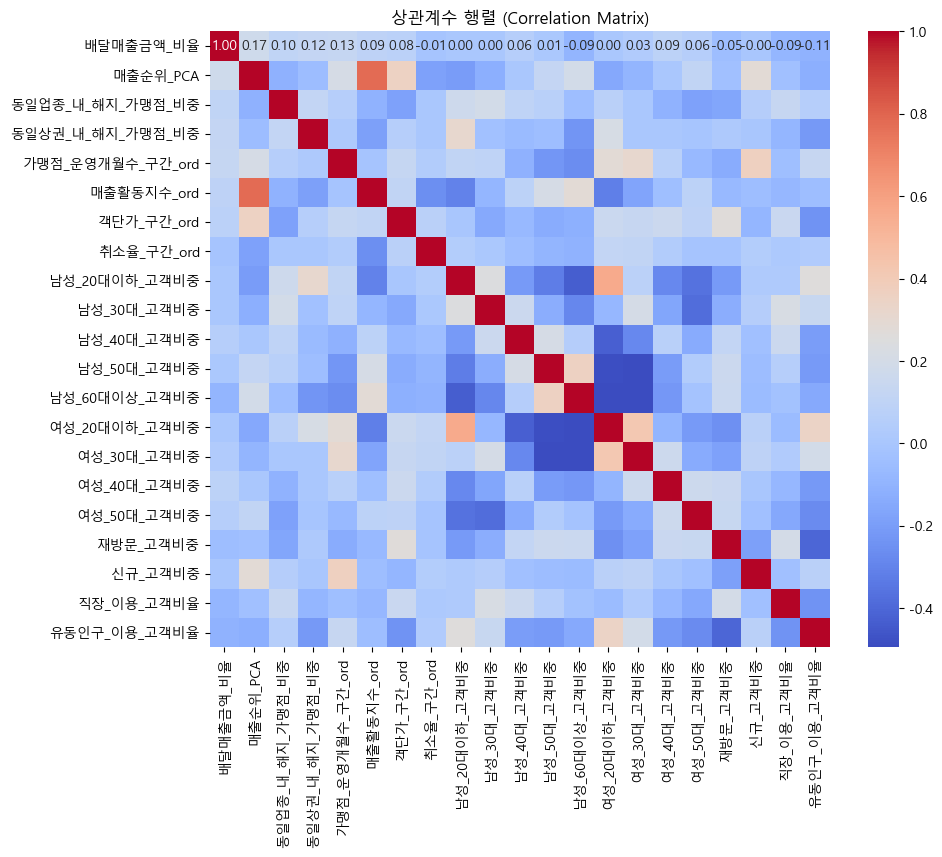

            Variable         VIF
0              const  442.370167
1          배달매출금액_비율    1.171835
2           매출순위_PCA    5.663663
3   동일업종_내_해지_가맹점_비중    1.221052
4   동일상권_내_해지_가맹점_비중    1.408510
5   가맹점_운영개월수_구간_ord    1.480779
6         매출활동지수_ord    5.116707
7         객단가_구간_ord    2.328950
8         취소율_구간_ord    1.082758
9      남성_20대이하_고객비중    5.222907
10       남성_30대_고객비중    3.553307
11       남성_40대_고객비중    2.519267
12       남성_50대_고객비중    2.785071
13     남성_60대이상_고객비중    5.901242
14     여성_20대이하_고객비중    6.361609
15       여성_30대_고객비중    4.097250
16       여성_40대_고객비중    2.510188
17       여성_50대_고객비중    3.621411
18          재방문_고객비중    1.748193
19           신규_고객비중    1.848515
20        직장_이용_고객비율    1.358723
21      유동인구_이용_고객비율    1.762332


In [65]:


plt.rcParams['axes.unicode_minus'] = False  # minus 기호 깨짐 방지


# 분석 대상 열 (수치형 또는 인코딩된 ordinal 변수만 포함)
#"거주_이용_고객비율", "여성_60대이상_고객비중"은 공선성을 위해 뺌
cols_for_check2 = [
    "배달매출금액_비율","매출순위_PCA","동일업종_내_해지_가맹점_비중","동일상권_내_해지_가맹점_비중",
    "가맹점_운영개월수_구간_ord","매출활동지수_ord",
    "객단가_구간_ord","취소율_구간_ord",
   "남성_20대이하_고객비중","남성_30대_고객비중","남성_40대_고객비중","남성_50대_고객비중","남성_60대이상_고객비중",
    "여성_20대이하_고객비중","여성_30대_고객비중","여성_40대_고객비중","여성_50대_고객비중",
    "재방문_고객비중","신규_고객비중","직장_이용_고객비율","유동인구_이용_고객비율"
]


# 1. 상관계수 행렬 시각화
corr = merged_pca[cols_for_check2].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("상관계수 행렬 (Correlation Matrix)")
plt.show()

# 2. VIF 계산
X = add_constant(merged_pca[cols_for_check2].dropna())  # 상수항 추가
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)


In [ ]:
corr_pairs = (
    corr.abs()
        .where(np.triu(np.ones(corr.shape), k=1).astype(bool)) # 상삼각만
        .stack()                                              # 긴 형태
        .sort_values(ascending=False)
)

top10_pairs = corr_pairs.head(10)
print(top10_pairs)

PCA_1          매출활동지수_ord       0.779809
남성_20대이하_고객비중  여성_20대이하_고객비중    0.560880
남성_50대_고객비중    여성_30대_고객비중      0.494863
남성_60대이상_고객비중  여성_30대_고객비중      0.494113
               여성_20대이하_고객비중    0.489240
남성_50대_고객비중    여성_20대이하_고객비중    0.487567
남성_20대이하_고객비중  남성_60대이상_고객비중    0.435871
남성_40대_고객비중    여성_20대이하_고객비중    0.426210
여성_20대이하_고객비중  여성_30대_고객비중      0.418088
재방문_고객비중       유동인구_이용_고객비율     0.404662
dtype: float64
